# Espacio de Estados

***Describir los sistemas en el espacio de estados y encontrar un controlador para esta representación.***

In [1]:
# Importamos librerias que utilizaremos en el notebook

%matplotlib inline

import control
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy
import sympy
import ipywidgets as widgets

sympy.init_printing()

!mkdir diagrams;

mkdir: cannot create directory ‘diagrams’: File exists


<table>
    <tr></tr>
    <tr>
        <td><img src="http://cpm.davinsony.com/clases/svg/python.svg" width="100px"></td>
        <td><img src="http://cpm.davinsony.com/clases/svg/sympy.svg" width="130px"></td>
        <td><img src="http://cpm.davinsony.com/clases/svg/matplotlib.svg" width="300px"></td>
        <td><img src="http://cpm.davinsony.com/clases/svg/numpy.svg" width="200px"></td>
        <td><img src="http://cpm.davinsony.com/clases/svg/ipywidgets.svg" width="200px"></td>
    </tr>
</table>

## Representación en el espacio de estados

Es una representación matricial de un sistema lineal la cual permite representar sistemas MIMO (multiple-input multiple-output) entre otros. La representación cuenta con dos ecuaciones:

- La ecuación de estado:

$$\dot{\mathbf{x}} = A\mathbf{x}+B\mathbf{u}$$

- La ecuación de salida:

$$\mathbf{y}=C\mathbf{x}+D\mathbf{u}$$

donde $\mathbf{x}$ es el vector de estados, $\mathbf{y}$ es el vector de salidas, $\mathbf{u}$ es el vector de entradas, $A$ es la matriz de estado, $B$ es la matriz de entrada, $C$ es la matriz de salida y $D$ es la matriz de transmision directa. 

In [2]:
%%file diagrams/ss_block.gv
// Closed loop diagram
digraph {
    graph [splines=ortho]
    rankdir = LR
    
    node[shape=none,width=0.4]
    u   [label="u"]
    y   [label="y"]
    
    node[style=filled, fillcolor=lightgray, shape=rectangle,width=0.7,height=0.7,fixedsize=false]
    SS  [label="ecuaciones del espacio de estados"]

    // Edges
    u -> SS -> y
}

Overwriting diagrams/ss_block.gv


In [3]:
from graphviz import Source
sourcefile = 'diagrams/ss_block.gv' 
gv = open(sourcefile)
dot = Source(gv.read(),engine="dot",format="svg",filename = sourcefile)
dot.render(sourcefile,view=False);

### Matrices del espacio de estados

- $A$ También conocida como la matriz dinámica, es la matriz más importante ya que contiene las leyes físicas que describe el sistema. 
- $B$ También conocida como la matriz de los actuadores. Muestra como las entradas afecta los estados, valores de B más grandes implica actuadores más poderosos. Esta matriz nos describe el comportamiento de los actuadores. 
- $C$ También conocida como la matriz de los sensores. Describe como podemos nosotros recibir información del sistema. 

Cuando nosotros diseñamos un sistema estamos diseñando dichas matrices. 

![](diagrams/ss_block.gv.svg)

Para el control del sistema, la pregunta es:

$$\textbf{¿Cómo debe ser la entrada seleccionada?}$$

para lograr que el sistema haga lo que yo quiero. 

## Estudiemos el espacio de estados 

Para esto usaremos la ecuación diferencial de un sistema masa-resorte-amortiguador (**MKC**).

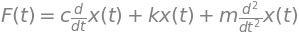

In [4]:
t,m,c,k = sympy.symbols('t m c k')
F = sympy.Function('F')(t)
x = sympy.Function('x')(t)

eqMKC = sympy.Eq(F,m*sympy.diff(x,t,2)+c*sympy.diff(x,t)+k*x)
display(eqMKC)

Inicialmente construyamos un diagrama de bloques que represente esta ecuación.

In [5]:
%%file diagrams/masa_resorte_amortiguador.gv
// Closed loop diagram
digraph {
    graph [splines=ortho]
    
    node[shape=point, fillcolor=black]
    N1  [pos="5.2,0!"]
    N2  [pos="7,0!"]
    
    node[shape=none,width=0.4]
    F   [pos="0,0!",label="F(s)"]
    X   [pos="8,0!",label="X(s)"]
    
    node[style=filled, fillcolor=lightgray,shape=circle, label="", width=0.3]
    S1  [pos="1,0!"]
    S2  [pos="2,0!"]
    
    node[shape=rectangle,width=0.7,height=0.7,fixedsize=true]
    iM  [pos="3,0!",label="1/m"]
    I1  [pos="4.5,0!",label="1/s"]
    I2  [pos="6,0!",label="1/s"]
    C   [pos="3,-1!",label="c"]
    K   [pos="3,-2!",label="k"]

    // Edges
    F  -> S1 -> S2  [headlabel="+"]
    S2 -> iM 
    iM -> I1        [taillabel=" s²X(s)"]
    I1 -> N1        [dir=none]
    N1 -> I2    
    I2 -> N2        [dir=none]
    N2 -> X
    N1 -> C
    C  -> S2        [headlabel="-  "]
    N2 -> K
    K  -> S1        [headlabel="-  "]
}

Overwriting diagrams/masa_resorte_amortiguador.gv


In [6]:
from graphviz import Source
sourcefile = 'diagrams/masa_resorte_amortiguador.gv' 
gv = open(sourcefile)
dot = Source(gv.read(),engine="neato",format="svg",filename = sourcefile)
dot.render(sourcefile,view=False);

### Diagrama de bloques del sistema MKC

![](diagrams/masa_resorte_amortiguador.gv.svg)

Se evidencia el uso de dos bloques integradores. El uso de estos bloques da indicios de los estados de este sistema, de cada bloque integrador tenemos, la posición $x(t)$ y la velocidad $\dot{x}(t)$ de la masa. Estos son los estados del sistema.  

### Construccion del vector de estados $x$

Sabemos del diagrama de bloques que la posición $x(t)$ y la velocidad $\dot{x}(t)$ son los estados del sistema.

Con estos podemos construir el vector de estados: 

$$\mathbf{x} = \left[\begin{array}{}\dot{x}(t)\\{x}(t)\end{array}\right] =\left[\begin{array}{}x_1\\x_2\end{array}\right]$$

Con $x_1$ y $x_2$, podemos reescribir la ecuación diferencial como:

In [7]:
x1, x2, dx1, dx2 = sympy.symbols('x_1 x_2 \dot{x}_1 \dot{x}_2')

eqMKC = eqMKC.subs(sympy.diff(x,t,2),dx1)
eqMKC = eqMKC.subs(sympy.diff(x,t),x1)
eqMKC = eqMKC.subs(x,x2)

sol_dx1 = sympy.Eq(dx1,sympy.expand(sympy.solve(eqMKC,dx1)[0]))
sol_dx2 = sympy.Eq(dx2,x1)
display(sol_dx1)

Falta la expresion para $\dot{x}_2$. La cual es simplemente 

$\dot{x}_2 = x_1$

De aquí ya podemos construir la ecuación de estado.

### Ecuación de estado para el sistema MKC

De la ecuaciones anteriores podemos contruir la ecuación matricial de estados:

In [8]:
MA = sympy.Symbol('A'); display(MA)
mA = sympy.Matrix([[-c/m,-k/m],[1,0]])
display(mA)

MD = sympy.Symbol('D'); display(MD)
display(sympy.Matrix([1/m,0]))

⎡-c   -k ⎤
⎢───  ───⎥
⎢ m    m ⎥
⎢        ⎥
⎣ 1    0 ⎦

⎡1⎤
⎢─⎥
⎢m⎥
⎢ ⎥
⎣0⎦

### Estabilidad del sistema MKC

Para verificar la estabilidad del sistema debemos evaluar los valores propios ($\lambda$) de la matriz $A$:

$$I-\lambda A$$

para encontrarlo encontremos la ecuación caracteristica con $\textbf{det}(I-\lambda A)$:

In [9]:
l = sympy.Symbol('\lambda')
caract = (sympy.eye(2)-l*mA).det();
display(caract)

de aquí los valores propios son: 

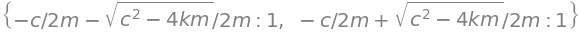

In [10]:
display(mA.eigenvals())

Vemos que son los mismos polos del sistema MKC si lo analizamos de forma clásica. 

# Una particula en una linea recta sin fricción

Diseñemos un control proporcional para el sistema propuesto, utilizando el espacio de estados.

$$m \ddot{x} = F$$

La ecuación de estado quedaría asi (con $m=1$). 

$$\dot{\mathbf{x}}=\left[\begin{array}{}0&1\\0&0\end{array}\right]\mathbf{x}+\left[\begin{array}{}0\\1\end{array}\right]\mathbf{u}$$

La ecuación de salida sería.

$$\mathbf{y}=\left[\begin{array}{}1&0\end{array}\right]\mathbf{x}$$

### Control de la particula

Si queremos controlar el sistema con un lazo cerrado debemos conectar de alguna forma la salida $\mathbf{y}$ con la entrada $\mathbf{u}$

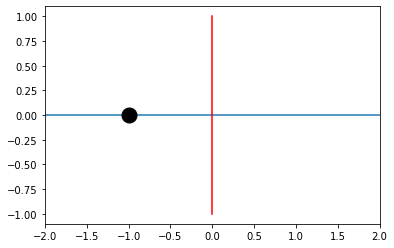

In [11]:
plt.plot([-2,2],[0,0])
plt.plot([0,0],[-1,1],color='r')
plt.plot([-1],[0],color='k',marker='.',markersize=30)
plt.xlim(-2,2);

El objetivo de control es que se mueva al origen. **¿Cómo lo logramos?**

$$\left.\begin{array}{}u>0 \text{ si } y<0 \\ u<0 \text{ si } y>0\end{array}\right\}\qquad \to \qquad u=-y$$

### Modificación de la dinamica del sistema 

En general tenemos: 

$$\mathbf{u}=-K\mathbf{y} = -KC\mathbf{x} $$

entonces: 

$$\dot{\mathbf{x}}=A\mathbf{x}+B\mathbf{u}=A\mathbf{x}-BKC\mathbf{x} = \left(A-BKC\right)\mathbf{x}$$

tenemos aquí un nuevo sistema, el sistema en lazo cerrado.

$$\dot{\mathbf{x}} = \left(A-BKC\right)\mathbf{x}=\hat{A}\mathbf{x}$$

nuestro trabajo ahora es seleccionar $K$ de tal forma que los valores propios de la matriz $\hat{A}$ den por lo menos un sistema estable. 

### La matriz de estado del sistema en lazo cerrado

Remplazamos los valores de las matrices y de $K=1$:

$$\hat{A}=\left(A-BKC\right)=\left(\left[\begin{array}{}0&1\\0&0\end{array}\right]-\left[\begin{array}{}0\\1\end{array}\right]1\left[\begin{array}{}1&0\end{array}\right]\right)$$

In [12]:
mA = sympy.Matrix([[0,1],[0,0]])-sympy.Matrix([0,1])*1*sympy.Matrix([[1,0]])
display(mA)

⎡0   1⎤
⎢     ⎥
⎣-1  0⎦

Analizando los valores propios del sistema tenemos que: 

In [13]:
display(mA.eigenvals())

El sistema es criticamente estable. 

### Respuesta de la particula al lazo cerrado

Con el controlador propuesto, la particula se comporta como se muestra. 

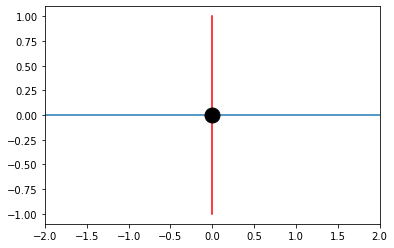

In [14]:
plt.rcParams["animation.html"] = "html5"#"jshtml"

t = numpy.linspace(0,2*numpy.pi,40)
x = numpy.sin(t)

fig, ax = plt.subplots();

ax.plot([-2,2],[0,0])
ax.plot([0,0],[-1,1],color='r')
plt.xlim(-2,2);
l, = ax.plot([0],[0],color='k',marker='.',markersize=30)

animate = lambda i: l.set_data([x[i]], [0]);

ani = FuncAnimation(fig, animate, frames=len(t), interval=1000/40);

In [15]:
display(ani)

**¿Por qué no se queda en el origen si este es el objetivo?**

- No tenemos en cuenta la velocidad. 
- Necesitamos la información del estado (posición,velocidad) del sistema para estabilizarlo.

### Estabilizando la particula 

Para estabilizar la particula necesitamos conocer la información de todos los estados del sistema. Salvo que en nuestro sistema solo tenemos un sensor de posición:

$$\mathbf{y}=\left[\begin{array}{}1&0\end{array}\right]\mathbf{x}$$

El estado desconocido es la velocidad, el cual puede ser estimado de la posición. Por ahora supongamos que podemos medir ambos estados. 

$$\mathbf{y}_{supuesto}=\left[\begin{array}{}1&0\\0&1\end{array}\right]\mathbf{x}$$

con esta nueva matriz $C$, proponemos un controlador $K$:

$$K = \left[\begin{array}{}k_1&k_2\end{array}\right]$$

Encontremos la nueva matriz $\hat{A}$ para el sistema en lazo cerrado.

### Nueva matriz de estado del sistema en lazo cerrado

Recordemos que aquí estamos suponiendo que podemos medir ambos estados del sistema (posición y velocidad). Remplazamos los valores de las matrices y de $K$:

$$\hat{A}=\left(A-BKC\right)=\left(\left[\begin{array}{}0&1\\0&0\end{array}\right]-\left[\begin{array}{}0\\1\end{array}\right]\left[\begin{array}{}k_1&k_2\end{array}\right]\left[\begin{array}{}1&0\\0&1\end{array}\right]\right)$$

Luego $\hat{A}=$

In [16]:
k1,k2 = sympy.symbols('k_1 k_2')
mA3 = sympy.Matrix([[0,1],[0,0]])-sympy.Matrix([0,1])*sympy.Matrix([[k1,k2]])*sympy.Matrix([[1,0],[0,1]])
display(mA3)

⎡ 0    1 ⎤
⎢        ⎥
⎣-k₁  -k₂⎦

Los valores propios o polos del sistema son:

In [17]:
eigen = mA3.eigenvals()
display(eigen)

### Escogamos los valores del controlador

In [18]:
## Parametros del modelo

paramK1 = widgets.FloatSlider(value=1,min=0,max=10,step=0.1,description='k1', orientation="vertical")
paramK2 = widgets.FloatSlider(value=2,min=0,max=5,step=0.1,description='k2', orientation="vertical")

## Definicion de la simulacion

def polos(K1,K2):
    P1 = -K2/2+sympy.sqrt(K2**2-4*K1)/2
    P2 = -K2/2-sympy.sqrt(K2**2-4*K1)/2
    plt.scatter([sympy.re(P1),sympy.re(P2)],[sympy.im(P1),sympy.im(P2)])
    plt.grid()
    plt.title('Polos de la Particula en lazo cerrado con sensores de posición y velocidad')
    plt.xlabel('Real')
    plt.ylabel('Imaginario')
    plt.ylim(-3,3)
    plt.xlim(-6,0)

## Presentación de los resultados    
    
plot_exponencial = widgets.interactive_output(polos,{'K1':paramK1,'K2':paramK2})      
widgets.HBox([paramK1,paramK2,plot_exponencial])

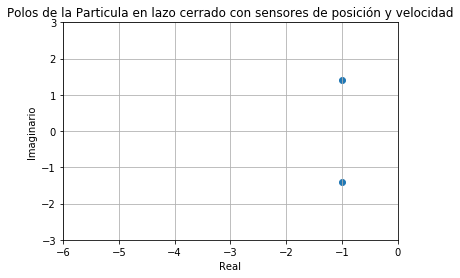

In [19]:
polos(3,2)

### Verifiquemos el comportamiento de la particula

Tomemos los valores para el controlador $k_1=1$ y $k_2=2$:

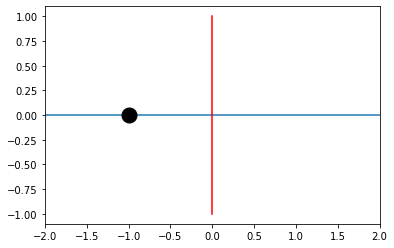

In [20]:
plt.rcParams["animation.html"] = "html5"#"jshtml"

particula = control.ss('0 1;-1 -2','1;0','1 0','0')
t,x = control.impulse_response(particula)

fig, ax = plt.subplots();

ax.plot([-2,2],[0,0])
ax.plot([0,0],[-1,1],color='r')
plt.xlim(-2,2);
l, = ax.plot([0],[0],color='k',marker='.',markersize=30)

animate = lambda i: l.set_data([-x[i]], [0]);

ani = FuncAnimation(fig, animate, frames=len(t), interval=1000/40);

In [21]:
display(ani)

## Posicionamiento de polos

El posicionamiento de polos nos permite definir el comportamiento deseado del sistema. Tomemos como ejemplo es caso anterior de la particula, cuya ecuación de estados se presenta a contuación:

$$\dot{\mathbf{x}}=\left[\begin{array}{}0&1\\0&0\end{array}\right]\mathbf{x}+\left[\begin{array}{}0\\1\end{array}\right]\mathbf{u}$$

A traves de la libreria de control de python, podemos obtener los valores del controlador que nos permita tener de comportamiento deseado. Con `contro.place(A,B,poles)` obtenemos los siguientes valores para los polos [-1,-2]

In [22]:
A4 = [[0,1],[0,0]]
B4 = [[0],[1]]

display(control.place(A4,B4,[-1,-2]))
#display(control.acker(A4,B4,[-1,-2]))

matrix([[2., 3.]])

### Contra ejemplo

Con el siguiente sistema no se le puede ubicar los polos. 

$$\dot{\mathbf{x}}=\left[\begin{array}{}2&0\\1&1\end{array}\right]\mathbf{x}+\left[\begin{array}{}1\\1\end{array}\right]\mathbf{u}$$

El controlador para dicho sistema seria: 

In [23]:
A4 = [[2,0],[1,1]]
B4 = [[1],[1]]

display(control.place(A4,B4,[-21,-20]))

matrix([[-6.36905167e+15,  6.36905167e+15]])